# LST_Tair #1

**Goal:** Derive Tair from smoothed LST (and NDVI) using regression-kriging

In [64]:
from datetime import date, timedelta
import datetime
import random
import re
import time

import geostatspy.geostats as geostats 
import geostatspy.GSLIB as GSLIB
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from progressbar import ProgressBar
from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split
import rasterio as rio
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
import statsmodels.formula.api as smf

**Functions**

Date functions

In [3]:
def fromstring(x):
    
    '''Converts string to datetime object'''
    
    try:
        d = datetime.datetime.strptime(x, '%d/%m/%Y').date()
    except:
        d = datetime.datetime.strptime(x, '%Y-%m-%d').date()
        
    return d

def fromdekad(x):

    # seeking for date pattern in the filename
    dek = re.search(r'\d{4}\d{2}D\d{1}', x).group()

    # getting year, month and dekad
    year = int(dek[0:4])
    month = int(dek[4:6])
    d = dek[6:8]
    
    if d=="D1":
        greg_date = date(year,month,10)
    elif d=="D2":
        greg_date = date(year,month,20)
    else:
        greg_date = date(year,month,28)
        
    return greg_date

Extracting time series 

In [4]:
def ts_time(location, T, LST):
    
    df = pd.DataFrame(np.nan, index=T.index, columns = ['T', 'LST'])
    df['T'] = T[location]
    df['LST'] = LST[location]
    df = df.dropna()

    return df

def ts_time_NDVI(location, T, LST, NDVI):
    
    df = pd.DataFrame(np.nan, index=T.index, columns = ['T', 'LST', 'NDVI'])
    df['T'] = T[location]
    df['LST'] = LST[location]
    df['NDVI'] = NDVI[location]
    df = df.dropna()

    return df

Extracting spatial series

In [5]:
def spatial_serie_NDVI(time_step, T, LST, NDVI):
    
    df = pd.DataFrame(np.nan, index=T.columns.values, columns = ['T', 'LST', 'NDVI'])
    df['T'] = T.loc[time_step].values
    df['LST'] = LST.loc[time_step].values
    df['NDVI'] = NDVI.loc[time_step].values

    return df

def spatial_serie(time_step, T, LST):
    
    df = pd.DataFrame(np.nan, index=T.columns.values, columns = ['T', 'LST'])
    df['T'] = T.loc[time_step].values
    df['LST'] = LST.loc[time_step].values

    return df

Plots

In [6]:
def plot_time(location, val, T, LST):

    if val == 'TNA':
        val2 = 'Tmin'
    else:
        val2 = 'Tmax'

    df = ts_time(location, T, LST)
    
    #Plotting
    X = df['LST'].values.reshape(-1, 1)
    Y = df['T'].values.reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X, Y)
    Ypred = lr.predict(X)
    plt.scatter(X, Y,  color='darkcyan')
    plt.xlabel(val)
    plt.ylabel(val2)
    plt.title('Scatter plot of one station over time')
    plt.plot(X, Ypred, color='red', linewidth=3)
    plt.show()
    
def plot_time_NDVI(location, val, T, LST, NDVI):

    if val == 'TNA':
        val2 = 'Tmin'
    else:
        val2 = 'Tmax'
    
    df = ts_time_NDVI(location, T, LST, NDVI)   

    #Plotting
    X = df["LST"].values.reshape(-1, 1)
    Y = df["T"].values.reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X, Y)
    Ypred = lr.predict(X)
    plt.scatter(X, Y,  c=df["NDVI"].values)
    plt.colorbar()
    plt.xlabel(val)
    plt.ylabel(val2)
    plt.title('Scatter plot of one station over time')
    plt.plot(X, Ypred, color='red', linewidth=3)
    plt.show()
     
    
def plot_station(time_step, val, T, LST, NDVI):
    
    if val == 'TNA':
        val2 = 'Tmin'
    else:
        val2 = 'Tmax'
    
    df = spatial_serie_NDVI(time_step, T, LST, NDVI)
    df = df.dropna()
    
    if df.empty:
        print('No data at this time step for ' + str(val))
        
    else:    
        #Plotting
        X = df["LST"].values.reshape(-1, 1)
        Y = df["T"].values.reshape(-1, 1)

        lr = LinearRegression()
        lr.fit(X, Y)
        Ypred = lr.predict(X)
        plt.scatter(X, Y,  c=df["NDVI"].values)
        plt.colorbar()
        plt.xlabel(val)
        plt.ylabel(val2)
        plt.title('Scatter plot of all stations at one time step')
        plt.plot(X, Ypred, color='red', linewidth=1)
        plt.show()

Linear Regression

In [7]:
def linear_reg(val, T, LST, NDVI, locs):
  
    df_reg = pd.DataFrame(columns = ['location', 'a', 'b', 'R square', 'NDVI mean', 'NDVI std'])
    
    for l in locs:

        #extracting ts at location
        df = ts_time_NDVI(l, T, LST, NDVI)
        
        #computing linear regression
        X = df["LST"].values.reshape(-1, 1)
        Y = df["T"].values.reshape(-1, 1)
        lr = LinearRegression()
        reg = lr.fit(X, Y)
        Ypred = lr.predict(X)
        r2 = lr.score(X, Y)
        
        #saving values in DataFrame
        df_reg = df_reg.append(pd.DataFrame([[l, reg.coef_[0][0], reg.intercept_[0], r2, np.mean(df["NDVI"]), np.std(df["NDVI"])]], columns=['location', 'a', 'b', 'R square', 'NDVI mean', 'NDVI std']))
        
    df_reg = df_reg.set_index('location')
    
    return df_reg

Kriging function

In [8]:
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    nug = vario['nug']; sill = nug 
    cc[0] = vario['cc1']; sill = sill + cc[0]
    it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; sill = sill + cc[1]
        it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];    

# set up the required matrices
    rotmat, maxcov = geostats.setup_rotmat(nug,nst,it,cc,ang,pmx)
    ndata = len(df); a = np.zeros([ndata,ndata]); r = np.zeros(ndata); s = np.zeros(ndata); rr = np.zeros(ndata)
    nest = len(dfl)

    est = np.zeros(nest); var = np.full(nest,sill); weights = np.zeros([nest,ndata])

# Make and solve the kriging matrix, calculate the kriging estimate and variance 
    pbar = ProgressBar()
    for iest in pbar(range(0,nest)):
        for idata in range(0,ndata):
            for jdata in range(0,ndata):
                a[idata,jdata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],df[xcol].values[jdata],df[ycol].values[jdata],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            r[idata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],dfl[xlcol].values[iest],dfl[ylcol].values[iest],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            rr[idata] = r[idata]
        
        s = geostats.ksol_numpy(ndata,a,r)    
        sumw = 0.0
        for idata in range(0,ndata):                          
            sumw = sumw + s[idata]
            weights[iest,idata] = s[idata]
            est[iest] = est[iest] + s[idata]*df[vcol].values[idata]
            var[iest] = var[iest] - s[idata]*rr[idata]
        est[iest] = est[iest] + (1.0-sumw)*skmean
        
    return est,var,weights 

**Downloading DATA**

In [9]:
#latlon pandas dataframe

latlon = pd.read_csv(
    'Data/lat.csv', 
    index_col = 0)

latlon = latlon.drop('Inhambane')
latlon = latlon.drop('Quelimane')

In [10]:
# Load dataframes

TNA = pd.read_csv('Data/dataframes/TNA.csv', index_col = 0, parse_dates = ['Date'])
TDA = pd.read_csv('Data/dataframes/TDA.csv', index_col = 0, parse_dates = ['Date'])

Tmin = pd.read_csv('Data/dataframes/Tmin.csv', index_col = 0, parse_dates = ['Date'])
Tmax = pd.read_csv('Data/dataframes/Tmax.csv', index_col = 0, parse_dates = ['Date'])

NDVI = pd.read_csv('Data/dataframes/NDVI.csv', index_col = 0, parse_dates = ['Date'])

&nbsp;

## Scatter plots

**Across time**

In [12]:
locs = TNA.columns.values

#location widget
location_widget = widgets.Dropdown(
    options=locs,
    value='Vilanculos',
    description='Select loc:')

location_widget

Dropdown(description='Select loc:', index=24, options=('Angoche', 'BeiraAero', 'Changalane', 'Chimoio', 'Chokw…

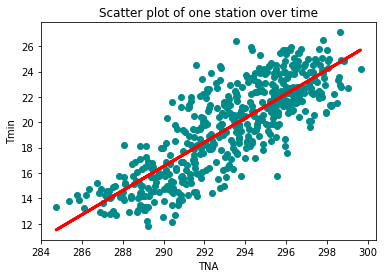

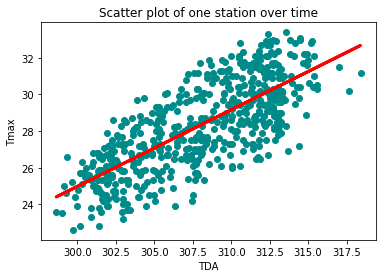

In [16]:
location = location_widget.value

plot_time(location, 'TNA', Tmin, TNA)
plot_time(location, 'TDA', Tmax, TDA)

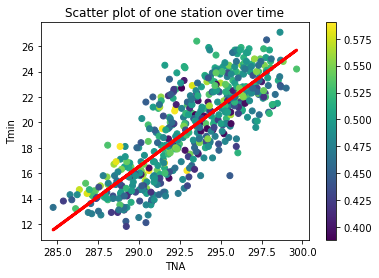

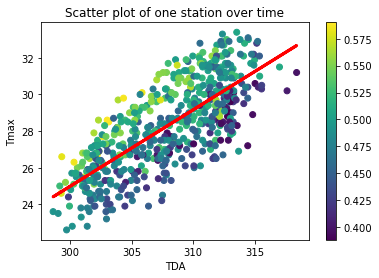

In [17]:
location = location_widget.value
plot_time_NDVI(location, 'TNA', Tmin, TNA, NDVI)
plot_time_NDVI(location, 'TDA', Tmax, TDA, NDVI)

We compute the linear regression for each location and we save the $a$ and $b$ parameters in a DataFrame

In [18]:
df_reg = linear_reg('TNA', Tmin, TNA, NDVI, locs)
df_reg[1:7]

,a,b,R square,NDVI mean,NDVI std
location,,,,,
BeiraAero,1.205743,-335.872529,0.787159,0.407988,0.065827
Changalane,0.966365,-263.394044,0.687231,0.594073,0.141418
Chimoio,0.750453,-201.179593,0.573306,0.506940,0.141725
Chokwe,0.844341,-229.407933,0.660129,0.357229,0.094761
Cuamba,0.717925,-190.925558,0.657776,0.520106,0.164021
Inharrime,0.935313,-252.891861,0.607653,0.688815,0.078888


In [19]:
df_reg = linear_reg('TDA', Tmax, TDA, NDVI, locs)
df_reg[1:7]

,a,b,R square,NDVI mean,NDVI std
location,,,,,
BeiraAero,0.445864,-109.564084,0.559347,0.409370,0.066127
Changalane,0.244720,-46.296557,0.365913,0.592304,0.140124
Chimoio,0.274726,-57.815550,0.468706,0.507633,0.141182
Chokwe,0.340855,-77.235421,0.588747,0.357053,0.094410
Cuamba,0.218890,-37.533263,0.436906,0.524925,0.163617
Inharrime,0.276539,-55.642272,0.329199,0.686949,0.078556


We try and find a correlation between the $a$ and $b$ parameters and NDVI

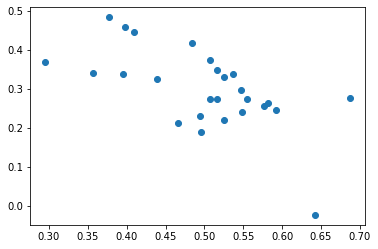

In [20]:
plt.scatter(df_reg['NDVI mean'], df_reg['a'])

**For a given time step**

In [21]:
time_step = '200501D3'

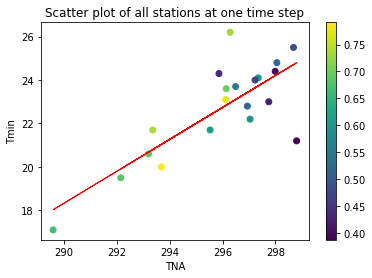

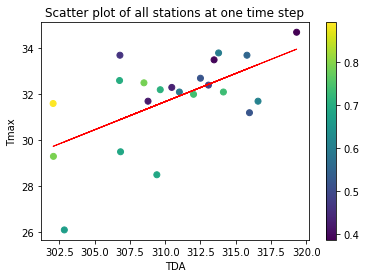

In [22]:
plot_station(fromdekad(time_step), 'TNA', Tmin, TNA, NDVI)
plot_station(fromdekad(time_step), 'TDA', Tmax, TDA, NDVI)

## Model 1

In [23]:
time_step = '200501D2'

We use a **regression-kriging** model to predict $T_{air}$: we use linear regression to fit the explanatory variation of Tmax and kriging to fit the residuals.

$T_{air}(s_0) = \sum_{k=1}^{n}\beta_k*p_k(s_0) + \sum_{i=1}^{28}\lambda_i*e(s_i)$

with $T_{air}$ the value to predict, $\beta_k$ the estimated regression coefficients, $p_k$ the predicators, $\lambda_i$ are the kriging weights determined by the spatial dependence structure of the residual and where $e(s_i)$ is the
residual at location $s_i$.


$LST$ is one of the predicators, lets test whether $NDVI$ is also one.

In [26]:
# Load data
dat = spatial_serie_NDVI(fromdekad(time_step), Tmax, TDA, NDVI)

# Fit regression model
results = smf.ols('T ~ LST + NDVI', data=dat).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      T   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     6.251
Date:                Wed, 30 Sep 2020   Prob (F-statistic):            0.00820
Time:                        11:28:11   Log-Likelihood:                -43.595
No. Observations:                  22   AIC:                             93.19
Df Residuals:                      19   BIC:                             96.46
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.9543     32.966     -1.364      0.1

$NDVI$'s pvalue is very high, so we don't reject the null hypothesis that the variable has no correlation with the dependent variable. Therefore we will **not use $NDVI$ to build our model**. 

**MODEL**

In [31]:
#BUILDING THE MODEL

m = LinearRegression(copy_X=True, fit_intercept=True)

# DATA
df = spatial_serie_NDVI(fromdekad(time_step), Tmax, TDA, NDVI)
df = df.sort_index()
df['Lat'] = latlon['Lat'].values
df['Lon'] = latlon['Lon'].values
df = df.dropna()
#p = np.array([[i,j] for i, j in zip(df['LST'].values, df['ndvi'].values)]) #predicators with NDVI
p = np.array([[i] for i in df['LST'].values]) #predicators without NDVI
x = np.array([[i,j] for i, j in zip(df['Lat'].values, df['Lon'].values)]) #locations
tmax = np.array(df['T'].values) #target


p_train, p_test, x_train, x_test, tmax_train, tmax_test = train_test_split(
    p, x, tmax, test_size=0.5
)

m_rk = RegressionKriging(regression_model=m)
m_rk.fit(p_train, x_train, tmax_train)
result = m_rk.predict(p_test, x_test)

Finished learning regression model
Finished kriging residuals


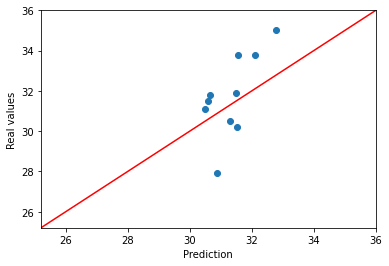

In [33]:
plt.scatter(result, tmax_test)
plt.xlabel('Prediction')
plt.xlim(min([*result, *tmax_test])+1,max([*result, *tmax_test])+1)
plt.ylabel('Real values')
plt.ylim(min([*result, *tmax_test])+1,max([*result, *tmax_test])+1)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), color = 'r')

We used half of the points to train the model, and half of them to test it. The result is not very satisfying because we only have a sample of 28 points (or less if we have no data at some locations) which is too small 

The problem is that **we only use spatial properties for this model**, because kriging is almost exclusively designed for the analysis of spatial data. However, the data we are using is poor in space, while rich in time. An idea would maybe be to try and use both temporal and spatial dimensions.

## Model 2

In this model we build a linear regression of $T_{air}$ as a function of $LST$ using leave one out cross validation. We then derive the residuals from the linear regression.

$\delta(i) = \hat{T_{air}(i)} - T_{air}(i)$ 

with $\hat{T_{air}(i)}$ the predicted values and $T_{air}(i)$ the real values at every station $i$


We then use **simple kriging** in order to get the residuals values over the entire AOI. 

In [34]:
time_step = '200501D2'

In [37]:
# DATA
df = spatial_serie_NDVI(fromdekad(time_step), Tmax, TDA, NDVI)
df = df.sort_index()
df['Lat'] = latlon['Lat'].values
df['Lon'] = latlon['Lon'].values
df = df.dropna()

#Training and test sets
X = df['LST'].values.reshape(-1,1)
Y = df['T']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#MODEL
lm = LinearRegression()
model = lm.fit(X_train, Y_train)
pred = model.predict(X_test)
MSE = mean_squared_error(Y_test, pred)    
print("MSE : ", MSE)

MSE :  8.90680165566225


**Leave-one-out cross validation**

In [44]:
model = lm.fit(X_train, Y_train)

loo = LeaveOneOut()
X = df['LST'].values.reshape(-1,1)
Y = df['T'].values.reshape(-1,1)
loo.get_n_splits(X)


crossvalidation = KFold(n_splits=22, random_state=None, shuffle=False)

scores = cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=1)

print("MSE: " + str(np.mean(np.abs(scores))))
print('scores', [round(x,3) for x in scores])

MSE: 3.913148573891445
scores [-0.0, -0.0, -2.698, -3.314, -0.144, -0.053, -31.708, -2.391, -0.435, -1.03, -1.178, -9.03, -4.053, -2.728, -4.284, -3.276, -7.761, -4.324, -2.949, -4.296, -0.035, -0.403]


Plotting points as a function of LOOCV score

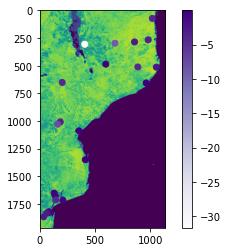

In [47]:
lat = df['Lat'].values
lon = df['Lon'].values

with rio.open('Data/test.tif') as src:
    aoi = src.read(1) 
    im = plt.imshow(aoi);
    coord = []
    for i in range(len(lat)):          
        coord.append(rio.transform.rowcol(src.transform, lon[i], lat[i]))
    lat2 = [i[0] for i in coord]
    lon2 = [i[1] for i in coord]
    plt.scatter(lon2,lat2, c = scores, cmap='Purples')
    plt.colorbar()

**Spatial kriging on the residuals**

In [48]:
pred = model.predict(X)
res = pred - df['T']

x = np.array([[i,j] for i, j in zip(df['Lat'].values, df['Lon'].values)]) #locations

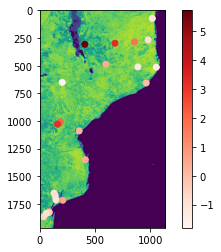

In [49]:
lat = df['Lat'].values
lon = df['Lon'].values

with rio.open('Data/test.tif') as src:
    aoi = src.read(1) 
    im = plt.imshow(aoi);
    coord = []
    for i in range(len(lat)):          
        coord.append(rio.transform.rowcol(src.transform, lon[i], lat[i]))
    lat2 = [i[0] for i in coord]
    lon2 = [i[1] for i in coord]
    plt.scatter(lon2,lat2, c = res, cmap='Reds')
    plt.colorbar()

Building the **variogram**

The first step of the kriging is too build our variogram which is a description of the spatial continuity of our data. It corresponds to the expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

We plot the variograms for different azimuths wih lag between 0 and 700 m. 

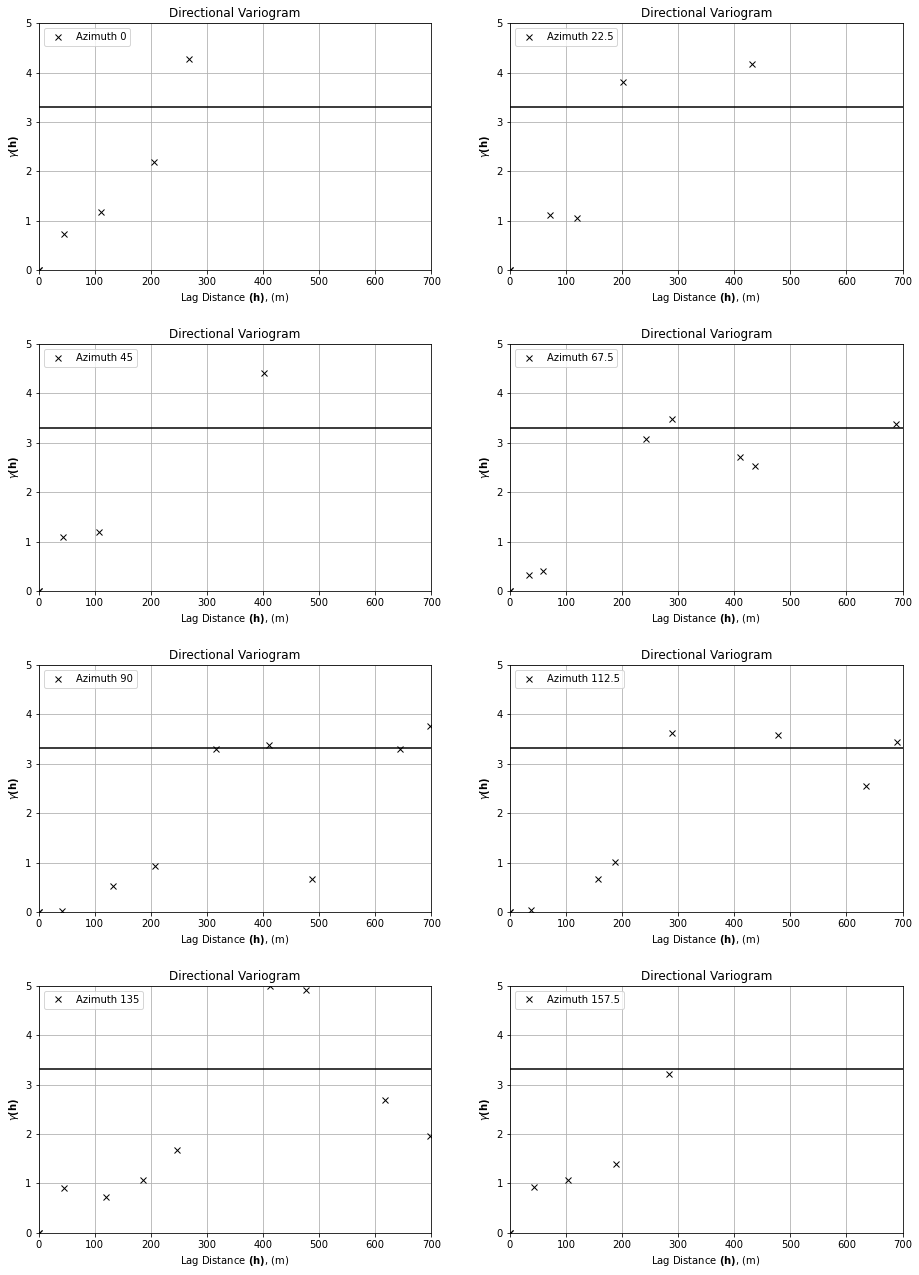

In [52]:
df = pd.DataFrame({'lat':lat2,'lon':lon2,'Value':res})

tmin = -9999.; tmax = 9999.                             
lag_dist = 100.0; lag_tol = 100.0; nlag = 8;            
bandh = 9999.9; atol = 22.5                             
isill = np.var(res)                                              
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5] 

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"lat","lon","Value",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[isill,isill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional Variogram')
    plt.xlim([0,700])
    plt.ylim([0,5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

Data is too sparseand as a result the directional variograms don't provide a very clear image of directionality. The ranges vary from 200m to 300 m.
We can observe that Azimuth 135 is the major direction.

From the results above, we build a variogram with the following parameters:

* **nug = 1.5** - Because we have an average nugget of 1.5 in all variograms

* **it1 = 3** - Because Gaussian

* **hmaj1 = hmin1 = 300** - We assume there is no directionality

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
 x,y,z offsets = 7.071067830903227,-7.071067792827723


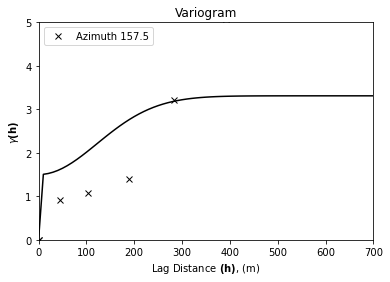

In [55]:
nug = 1.5    
nst = 1
it1 = 3      
c1 = isill-nug
azi = 0
hmaj1 = 300
hmin1 = 300
vario = GSLIB.make_variogram(nug,nst,it1,c1,azi,hmaj1,hmin1);
nlag = 70; xlag = 10;                                          
index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi_mat[6],vario) 
  
nb = 7

plt.plot(lag[nb,:],gamma[nb,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[nb]))
plt.plot(h_maj,gam_maj,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variogram')
plt.xlim([0,700])
plt.ylim([0,5])
plt.legend(loc='upper left')

**Kriging**

Kriging is extremely time consuming. To start with, we will only do kriging for 500 random points over the AOI.

100% |########################################################################|


--- 12.243311166763306 seconds ---


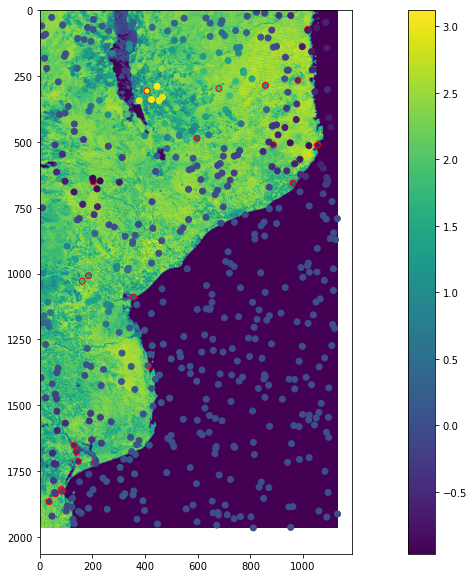

In [60]:
x = [random.randint(0,1966) for i in range(500)]
y = [random.randint(0,1131) for i in range(500)]
dfl = pd.DataFrame({'X':x,'Y':y})


start_time = time.time()

sk_est, sk_var, sk_weights =  simple_simple_krige(df,'lat','lon','Value',dfl,'X','Y', vario, skmean=0.0)

print("--- %s seconds ---" % (time.time() - start_time))

with rio.open('Data/test.tif') as src:
    plt.figure(figsize=(20,10))
    aoi = src.read(1) 
    im = plt.imshow(aoi);
    plt.scatter(lon2,lat2, c = res, linewidths=1, edgecolors='red')
    plt.scatter(y,x, c = sk_est)
    plt.colorbar()

10000 points

In [61]:
x = [random.randint(0,1966) for i in range(10000)]
y = [random.randint(0,1131) for i in range(10000)]
dfl = pd.DataFrame({'X':x,'Y':y})


start_time = time.time()

sk_est, sk_var, sk_weights =  simple_simple_krige(df,'lat','lon','Value',dfl,'X','Y', vario, skmean=0.0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 168.7439739704132 seconds ---


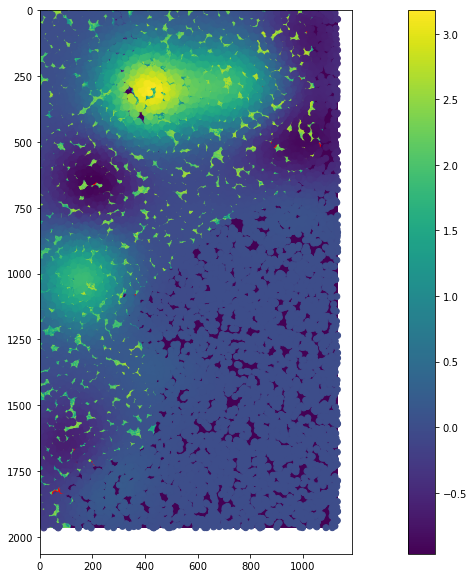

In [62]:
with rio.open('Data/test.tif') as src:
    plt.figure(figsize=(20,10))
    aoi = src.read(1) 
    im = plt.imshow(aoi);
    plt.scatter(lon2,lat2, c = res, linewidths=1, edgecolors='red')
    plt.scatter(y,x, c = sk_est)
    plt.colorbar()

**Interpolating to the entire AOI ?**

One first solution would be to use kriging over 10000 points and then use classical interpolation for the rest of the map

In [65]:
lat_all = np.concatenate((lat2, x))
lon_all = np.concatenate((lon2, y))
points_all = np.vstack((lat_all, lon_all)).T

val_all = np.concatenate((res, sk_est))

grid_x, grid_y = np.mgrid[0:1966, 0:1131]

grid = griddata(points_all, val_all, (grid_x, grid_y), method='nearest')

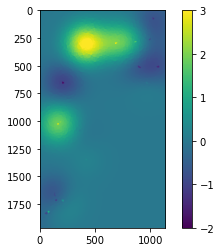

In [66]:
plt.imshow(grid)
plt.clim(-2,3)
plt.colorbar()

Other solution: 
 - use Cython ?
 - use gstat `R` package